<a href="https://colab.research.google.com/github/yudam-J/KDC-classification-with-BERT/blob/main/KDC_classification(KoBERT_%EC%B5%9C%EC%86%8C%EB%A0%88%EC%BD%94%EB%93%9C_25_2_13).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Functions & Module Import

In [1]:
import pandas as pd
import os
import sys
import urllib.request
import json
import re
import numpy as np
from google.colab import drive
from glob import glob

# drive.mount('/content/drive/')
# os.chdir('/content/drive/MyDrive/work_dir')

pd.set_option('display.float_format', '{:.0f}'.format)

In [3]:
combined_df = pd.read_csv('/content/kdc_data.csv', low_memory=False)

#Data Preprocessing

## (1) Data Load and Combine

In [ ]:
"""
지정된 경로의 파일을 불러와 하나의 데이터프레임으로 병합합니다.
"""
csv_files = glob(os.path.join('/content/drive/MyDrive/work_dir', "NL_BO_SPECIES_MASTER_NEW*.csv"))

# 각 파일을 읽고 리스트에 추가하여 병합
dataframes = []
for file in csv_files:
    df = pd.read_csv(file)
    dataframes.append(df)

# 모든 데이터를 하나의 데이터프레임으로 결합
df_2 = pd.concat(dataframes, ignore_index=True)

<ipython-input-4-15d402cc761f>:9: DtypeWarning: Columns (6,11,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
<ipython-input-4-15d402cc761f>:9: DtypeWarning: Columns (7,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
<ipython-input-4-15d402cc761f>:9: DtypeWarning: Columns (6,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
<ipython-input-4-15d402cc761f>:9: DtypeWarning: Columns (11,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
<ipython-input-4-15d402cc761f>:9: DtypeWarning: Columns (1,6,7,9,10,11,12,13,14,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
<ipython-input-4-15d402cc761f>:9: DtypeWarning: Columns (1,7,10,11,12,13,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read

In [ ]:
df_2.columns

Index(['SEQ_NO', 'ISBN_THIRTEEN_NO', 'VLM_NM', 'TITLE_NM', 'AUTHR_NM',
       'PUBLISHER_NM', 'PBLICTE_DE', 'ADTION_SMBL_NM', 'PRC_VALUE',
       'IMAGE_URL', 'BOOK_INTRCN_CN', 'KDC_NM', 'TITLE_SBST_NM',
       'AUTHR_SBST_NM', 'TWO_PBLICTE_DE', 'INTNT_BOOKST_BOOK_EXST_AT',
       'PORTAL_SITE_BOOK_EXST_AT', 'ISBN_NO'],
      dtype='object')

In [ ]:
df_2 = df_2[["TITLE_NM", "ISBN_THIRTEEN_NO", "BOOK_INTRCN_CN", "KDC_NM"]]

In [ ]:
df_2 = df_2.dropna(subset=['KDC_NM'])
nan_count_per_column = df_2.isna().sum()
print(nan_count_per_column)

TITLE_NM                  0
ISBN_THIRTEEN_NO          0
BOOK_INTRCN_CN      1392396
KDC_NM                    0
dtype: int64


In [ ]:
df_2 = df_2.dropna(subset=['BOOK_INTRCN_CN'])
nan_count_per_column = df_2.isna().sum()
print(nan_count_per_column)

TITLE_NM            0
ISBN_THIRTEEN_NO    0
BOOK_INTRCN_CN      0
KDC_NM              0
dtype: int64


In [ ]:
df_2.shape

(1050904, 4)

In [ ]:
df_2 = df_2.drop_duplicates(subset=['ISBN_THIRTEEN_NO'])
df_2.shape

(860476, 4)

In [ ]:
duplicate_counts = df_2['BOOK_INTRCN_CN'].value_counts()
# 중복된 값만 필터링 (2번 이상 나타나는 값)
duplicates = duplicate_counts[duplicate_counts > 1]

print(duplicates)

BOOK_INTRCN_CN
[해외주문원서] 고객님의 요청으로 수입 주문하는 도서이므로, 주문취소 및 반품이 불가합니다. (단, 재고부족인 경우는 가능)                                                                                                                 4966
이 책은 해당 분야 전공자들을 위한 교재 겸 전문서이다.                                                                                                                                                        255
▶ 이 책은 영어로 구성되어 있습니다.                                                                                                                                                                  208
어린이들을 위한 음악교재이다. 어린이들이 쉽게 따라할 수 있도록 구성되어 있다.                                                                                                                                           199
명문대 선정 세계문학 시리즈. 우리 나라의 대표적인 아동문학가들이 초등학교 아이들이 읽기에 알맞은 작품을 선정, 다듬어 실었다. 또 책 뒤에는 명문대학 국문과 교수들이 해설한 작가의 작품론과 철학과 교수들이 출제한 논술 길잡이를 수록했다.                                                  142
                                                  

In [ ]:
# 삭제할 행을 찾기 위한 조건 설정
df_2 = df_2[df_2['BOOK_INTRCN_CN'] != "[해외주문원서] 고객님의 요청으로 수입 주문하는 도서이므로, 주문취소 및 반품이 불가합니다. (단, 재고부족인 경우는 가능)"]
df_2.shape

(855510, 4)

In [ ]:
df_2.rename(columns={"BOOK_INTRCN_CN": "description"}, inplace=True)

<ipython-input-13-64fb631bd86b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2.rename(columns={"BOOK_INTRCN_CN": "description"}, inplace=True)


In [ ]:
df_2.columns

Index(['TITLE_NM', 'ISBN_THIRTEEN_NO', 'description', 'KDC_NM'], dtype='object')

In [ ]:
df.columns

Index(['SEQ_NO', 'ISBN_THIRTEEN_NO', 'VLM_NM', 'TITLE_NM', 'AUTHR_NM',
       'PUBLISHER_NM', 'PBLICTE_DE', 'ADTION_SMBL_NM', 'PRC_VALUE',
       'IMAGE_URL', 'BOOK_INTRCN_CN', 'KDC_NM', 'TITLE_SBST_NM',
       'AUTHR_SBST_NM', 'TWO_PBLICTE_DE', 'INTNT_BOOKST_BOOK_EXST_AT',
       'PORTAL_SITE_BOOK_EXST_AT', 'ISBN_NO'],
      dtype='object')

In [ ]:
!pip install transformers torch

In [ ]:
def load_and_combine_csv(directory_path):
    """
    지정된 경로의 chunk*.csv 파일을 불러와 하나의 데이터프레임으로 병합합니다.
    """
    csv_files = glob(os.path.join(directory_path, "chunk*.csv"))

    # 각 파일을 읽고 리스트에 추가하여 병합
    dataframes = []
    for file in csv_files:
        df = pd.read_csv(file)
        dataframes.append(df)

    # 모든 데이터를 하나의 데이터프레임으로 결합
    combined_df = pd.concat(dataframes, ignore_index=True)
    return combined_df

In [ ]:
combined_df = load_and_combine_csv("/content/drive/MyDrive/work_dir")
combined_df

,TITLE_NM,ISBN_THIRTEEN_NO,KDC_NM,description
0,(청소년 지도사가 쓴)청소년복지론,9788991495227,338,No description available
1,펀드보다 안전한 가치 투자=:,9788957820285,328,No description available
2,지식의 발견=:,9788976829511,309,『지식의 발견』은 출판 담당 기자 출신의 저자가 한국의 대표적 지식인들이 근대성과 ...
3,육경과 공자 인학=(The)six books and Confucius jenlogy,9788976461742,152,이 책은 해당 분야 전공자들을 위한 교재 겸 전문서이다.
4,나노테크놀러지 최전선 기술,9788970442372,530,나노 과학과 기술에 관심이 있는 사람을 위해 나노과학의 첨단을 달리고 있는 일본의 ...
...,...,...,...,...
137695,생쥐 각시 시집가네,9788953515130,375,No description available
137696,산에 산에 가다가,9788953515154,375,No description available
137697,자장자장 잘도 잔다,9788953515161,375,No description available
137698,사또네 잔칫날,9788953515178,375,No description available


In [ ]:
combined_df = combined_df[combined_df['description'] != "No description available"]
combined_df

,TITLE_NM,ISBN_THIRTEEN_NO,KDC_NM,description
2,지식의 발견=:,9788976829511,309,『지식의 발견』은 출판 담당 기자 출신의 저자가 한국의 대표적 지식인들이 근대성과 ...
3,육경과 공자 인학=(The)six books and Confucius jenlogy,9788976461742,152,이 책은 해당 분야 전공자들을 위한 교재 겸 전문서이다.
4,나노테크놀러지 최전선 기술,9788970442372,530,나노 과학과 기술에 관심이 있는 사람을 위해 나노과학의 첨단을 달리고 있는 일본의 ...
17,고분미술,9788981337414,609,"인간의 죽음에 대하여 의미를 부여하고, 또 죽음을 애도하는 과정에서 생겨난 상장례와..."
18,고분미술,9788981337421,609,옛 무덤에서 발견되는 유물은 단순한 유물이 아닌 당대의 문화의 산물입니다. 때문에 ...
...,...,...,...,...
137667,(피라미드에서 우주선까지)세계의 불가사의,9788952738349,31,바빌론의 공중 정원은 왜 만들어졌을까? 콜로서스의 로도스 상은 언제 무너졌을까? 알...
137671,달콤 쌉싸름한 초콜릿,9788937461088,873,22년동안 이어진 애절한 사랑 이야기!\n\n멕시코의 소설가 라우라 에스키벨의 첫 ...
137677,정부와 NGO,9788918021683,339,NaN
137680,응력해석 및 재료거동학,9788971416204,530,NaN


In [ ]:
# 기존 구축 데이터 병합
combined_df = pd.concat([combined_df, df_2], ignore_index=True)

In [ ]:
combined_df.shape

(943508, 4)

In [ ]:
combined_df = combined_df.drop_duplicates(subset='ISBN_THIRTEEN_NO', keep='first').reset_index(drop=True)

In [ ]:
combined_df.shape

(919595, 4)

In [ ]:
combined_df.isna().sum()

,0
TITLE_NM,0
ISBN_THIRTEEN_NO,0
KDC_NM,0
description,2515


In [ ]:
combined_df = combined_df.dropna(subset=['description'])

In [ ]:
combined_df.dtypes

,0
TITLE_NM,object
ISBN_THIRTEEN_NO,object
KDC_NM,object
description,object


## (2) 라벨 불균형 해결

In [4]:
from collections import Counter  # Counter 객체를 collections 모듈에서 임포트

label_counts = Counter(combined_df['KDC_NM'])
labels_over_500 = {label for label, count in label_counts.items() if count > 500}

# 필터링하여 새로운 데이터프레임 생성
combined_df = combined_df[combined_df['KDC_NM'].isin(labels_over_500)].copy()

# 결과 확인
print(combined_df.shape)
print(combined_df['KDC_NM'].value_counts())
print(len(combined_df['KDC_NM'].value_counts()))

(528843, 4)
KDC_NM
813.7    56540
813.6    35035
830.0    32274
843.0    17811
833.6    17427
         ...  
5.11       511
235.7      510
235.0      504
892.8      501
331.1      501
Name: count, Length: 248, dtype: int64
248


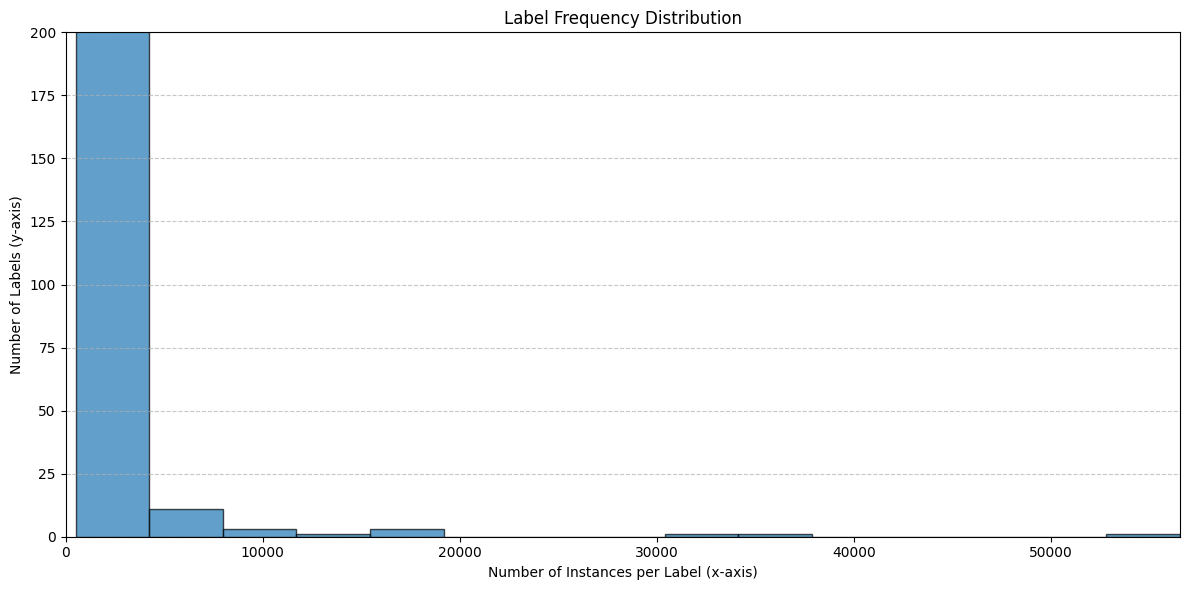

In [5]:
from collections import Counter  # Counter 객체를 collections 모듈에서 임포트
import matplotlib.pyplot as plt # Import matplotlib

# 각 라벨의 빈도수 계산
label_counts = Counter(combined_df['KDC_NM'])

# 라벨의 빈도수 (x축에 해당)
label_frequencies = list(label_counts.values())

# 적절한 bin 개수 결정 (빈도수의 분포를 기준으로)
n_bins = int(np.sqrt(len(label_frequencies)))  # 빈도수에 대해 제곱근 법칙 적용

# 라벨 빈도수로 히스토그램 구간 설정
plt.figure(figsize=(12, 6))

# 히스토그램 그리기
plt.hist(
    label_frequencies,  # 라벨 빈도수 사용
    bins=n_bins,  # 동적으로 계산된 bin 개수
    edgecolor='black',
    alpha=0.7
)

# x축 최대값을 label_frequencies의 최댓값으로 설정
plt.xlim(0, max(label_frequencies))
plt.ylim(0, 200)

# 그래프 설정
plt.title('Label Frequency Distribution')
plt.xlabel('Number of Instances per Label (x-axis)')
plt.ylabel('Number of Labels (y-axis)')

# x축에 라벨 빈도수 표시, y축에는 레이블 개수 표시
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  # 레이아웃 조정
plt.show()

### Data Augmentation

In [6]:
# !pip install nltk
import nltk
# nltk.download('punkt_tab')
# nltk.download('wordnet')
# nltk.download('omw-1.4')
import random
import pickle
import re

In [7]:
# 한글만 남기고 나머지는 삭제
def get_only_hangul(line):
	parseText= re.compile('/ ^[ㄱ-ㅎㅏ-ㅣ가-힣]*$/').sub('',line)

	return parseText

########################################################################
# Synonym replacement
# Replace n words in the sentence with synonyms from wordnet
########################################################################

def synonym_replacement(words, n):
	new_words = words.copy()
	random_word_list = list(set([word for word in words]))
	random.shuffle(random_word_list)
	num_replaced = 0
	for random_word in random_word_list:
		synonyms = get_synonyms(random_word)
		if len(synonyms) >= 1:
			synonym = random.choice(list(synonyms))
			new_words = [synonym if word == random_word else word for word in new_words]
			num_replaced += 1
		if num_replaced >= n:
			break

	if len(new_words) != 0:
		sentence = ' '.join(new_words)
		new_words = sentence.split(" ")

	else:
		new_words = ""

	return new_words

def get_synonyms(word):
	synomyms = []

	try:
		for syn in wordnet[word]:
			for s in syn:
				synomyms.append(s)
	except:
		pass

	return synomyms

########################################################################
# Random deletion
# Randomly delete words from the sentence with probability p
########################################################################
def random_deletion(words, p):
	if len(words) == 1:
		return words

	new_words = []
	for word in words:
		r = random.uniform(0, 1)
		if r > p:
			new_words.append(word)

	if len(new_words) == 0:
		rand_int = random.randint(0, len(words)-1)
		return [words[rand_int]]

	return new_words

########################################################################
# Random swap
# Randomly swap two words in the sentence n times
########################################################################
def random_swap(words, n):
	new_words = words.copy()
	for _ in range(n):
		new_words = swap_word(new_words)

	return new_words

def swap_word(new_words):
	random_idx_1 = random.randint(0, len(new_words)-1)
	random_idx_2 = random_idx_1
	counter = 0

	while random_idx_2 == random_idx_1:
		random_idx_2 = random.randint(0, len(new_words)-1)
		counter += 1
		if counter > 3:
			return new_words

	new_words[random_idx_1], new_words[random_idx_2] = new_words[random_idx_2], new_words[random_idx_1]
	return new_words

########################################################################
# Random insertion
# Randomly insert n words into the sentence
########################################################################
def random_insertion(words, n):
	new_words = words.copy()
	for _ in range(n):
		add_word(new_words)

	return new_words

def add_word(new_words):
	synonyms = []
	counter = 0
	while len(synonyms) < 1:
		if len(new_words) >= 1:
			random_word = new_words[random.randint(0, len(new_words)-1)]
			synonyms = get_synonyms(random_word)
			counter += 1
		else:
			random_word = ""

		if counter >= 10:
			return

	random_synonym = synonyms[0]
	random_idx = random.randint(0, len(new_words)-1)
	new_words.insert(random_idx, random_synonym)

In [8]:
def augment_data(data, label_column, text_column, target_count):
    """
    Args:
        data (pd.DataFrame): 원본 데이터프레임
        label_column (str): 라벨 컬럼명
        text_column (str): 텍스트 컬럼명
        target_count (int): 라벨별 최소 인스턴스 수

    Returns:
        pd.DataFrame: 증강된 데이터프레임
    """
    augmented_data = []
    label_counts = Counter(data[label_column])

    for label, count in label_counts.items():
        label_data = data[data[label_column] == label]
        texts = label_data[text_column].tolist()

        # 증강 대상 라벨 처리
        if count < target_count:
            needed = target_count - count

            for _ in range(needed):
                # 원본 데이터 중 하나 선택
                original_text = random.choice(texts)
                original_text = str(original_text)
                words = original_text.split()

                # 랜덤으로 증강 기법 선택
                augmentation_methods = [
                    lambda w: " ".join(random_deletion(w, p=0.1)),
                    lambda w: " ".join(random_swap(w, n=2)),
                    lambda w: " ".join(random_insertion(w, n=2)),
                    lambda w: " ".join(synonym_replacement(w, n=2))
                ]

                augmented_text = random.choice(augmentation_methods)(words)

                # 증강된 텍스트와 라벨 저장, 나머지 열은 원본에서 가져옴
                augmented_row = {label_column: label, text_column: augmented_text}
                for column in data.columns:
                    if column not in [label_column, text_column]:
                        augmented_row[column] = label_data[column].iloc[0]

                augmented_data.append(augmented_row)

    # 증강 데이터와 원본 데이터 병합
    augmented_df = pd.DataFrame(augmented_data)
    final_data = pd.concat([data, augmented_df], ignore_index=True)
    return final_data

In [9]:
augmented_df = augment_data(combined_df, "KDC_NM", "description", 1000)

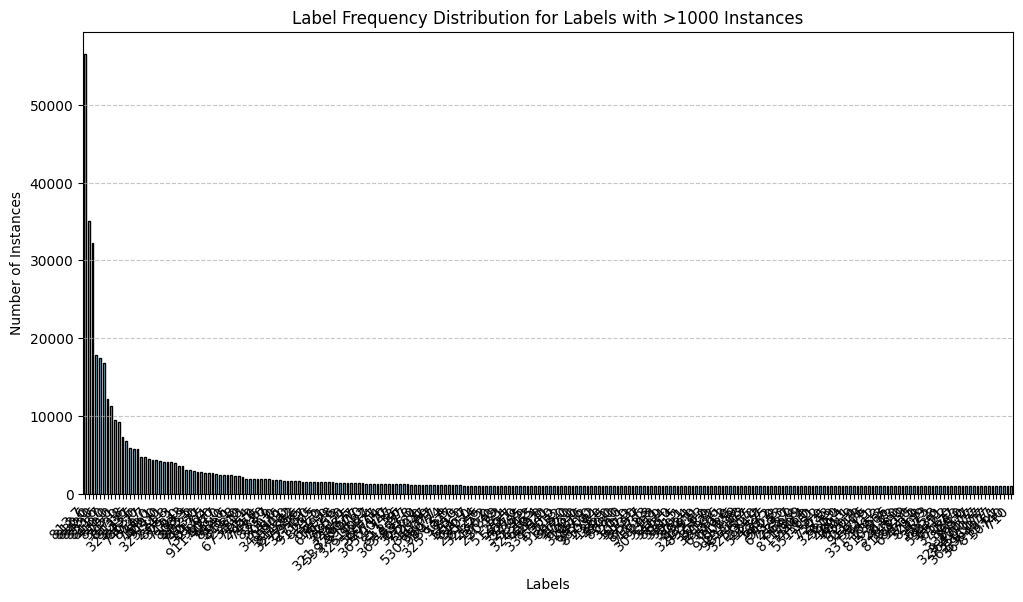

In [10]:
# 그래프 그리기
plt.figure(figsize=(12, 6))
augmented_df['KDC_NM'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Label Frequency Distribution for Labels with >1000 Instances')
plt.xlabel('Labels')
plt.ylabel('Number of Instances')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [13]:
augmented_df.shape

(571898, 4)

In [14]:
len(augmented_df['KDC_NM'].value_counts())

248

In [15]:
augmented_df['KDC_NM'].value_counts()

,count
KDC_NM,
813.7,56540
813.6,35035
830.0,32274
843.0,17811
833.6,17427
...,...
367.4077,1000
813.61,1000
307.7,1000


### Random Under Sampling

In [11]:
from sklearn.utils import resample

def random_undersample(data, label_column, target_count):
    """
    지정된 target_count보다 많은 라벨의 데이터를 랜덤하게 줄이는 함수.

    Args:
        data (pd.DataFrame): 원본 데이터프레임
        label_column (str): 라벨 컬럼명
        target_count (int): 목표 라벨의 최소 인스턴스 수

    Returns:
        pd.DataFrame: 랜덤 언더샘플링 후의 데이터프레임
    """
    undersampled_data = []

    # 각 라벨별 인스턴스 개수 세기
    label_counts = data[label_column].value_counts()

    for label, count in label_counts.items():
        label_data = data[data[label_column] == label]

        # 라벨의 개수가 target_count보다 많을 경우 랜덤하게 줄이기
        if count > target_count:
            # target_count로 샘플링
            label_data = resample(label_data,
                                  replace=False,  # 샘플링은 중복 없이
                                  n_samples=target_count,  # 지정된 개수만큼
                                  random_state=42)

        # 언더샘플링된 데이터 저장
        undersampled_data.append(label_data)

    # 리스트로 저장된 모든 데이터를 하나로 합침
    final_data = pd.concat(undersampled_data, ignore_index=True)

    return final_data

In [12]:
final_df = random_undersample(augmented_df, "KDC_NM", 10000)

In [13]:
final_df.shape

(452540, 4)

In [14]:
final_df.isna().sum()

,0
TITLE_NM,0
ISBN_THIRTEEN_NO,0
KDC_NM,0
description,0


In [15]:
final_df = final_df.dropna(subset=['description'])

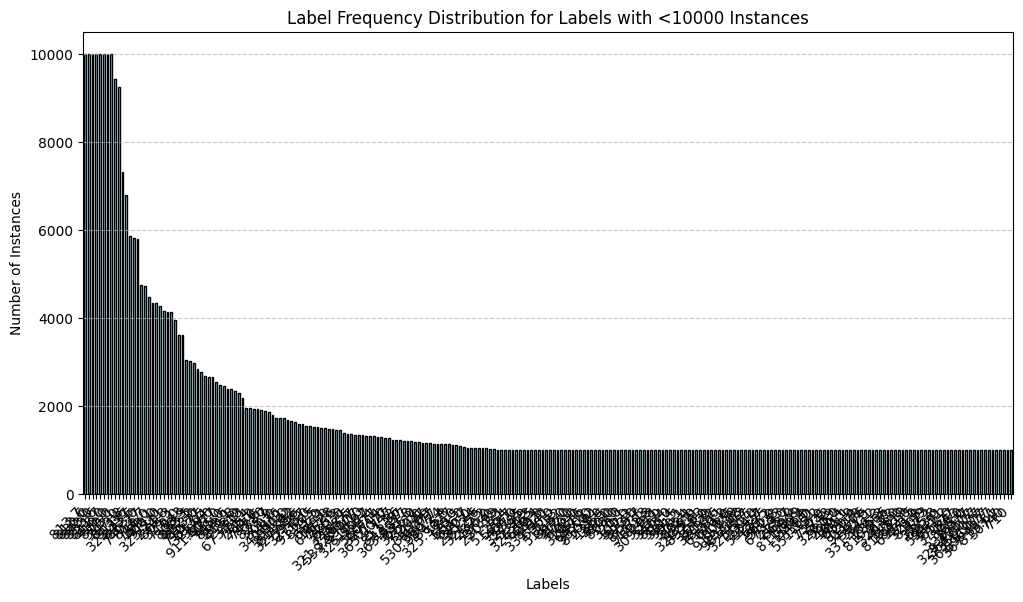

In [16]:
# 그래프 그리기
plt.figure(figsize=(12, 6))
final_df['KDC_NM'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Label Frequency Distribution for Labels with <10000 Instances')
plt.xlabel('Labels')
plt.ylabel('Number of Instances')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [17]:
len(final_df['KDC_NM'].unique())

248

## 5000, 1000, 500 체크

In [ ]:
combined_df['KDC_NM'] = combined_df['KDC_NM'].astype(str).str.strip().str.replace(" ", "", regex=True)
combined_df['KDC_NM'] = combined_df['KDC_NM'].astype(str)

In [ ]:
label_counts = Counter(combined_df['KDC_NM'])
labels_over_5000 = {label for label, count in label_counts.items() if count > 500}

# 필터링하여 새로운 데이터프레임 생성
df_over5000 = combined_df[combined_df['KDC_NM'].isin(labels_over_5000)].copy()

# 결과 확인
print(df_over5000.shape)
print(df_over5000['KDC_NM'].value_counts())
print(len(df_over5000['KDC_NM'].value_counts()))

(528845, 4)
KDC_NM
813.7    56540
813.6    35036
830.0    32274
843.0    17811
833.6    17427
         ...  
5.11       511
235.7      510
235.0      504
892.8      501
331.1      501
Name: count, Length: 248, dtype: int64
248


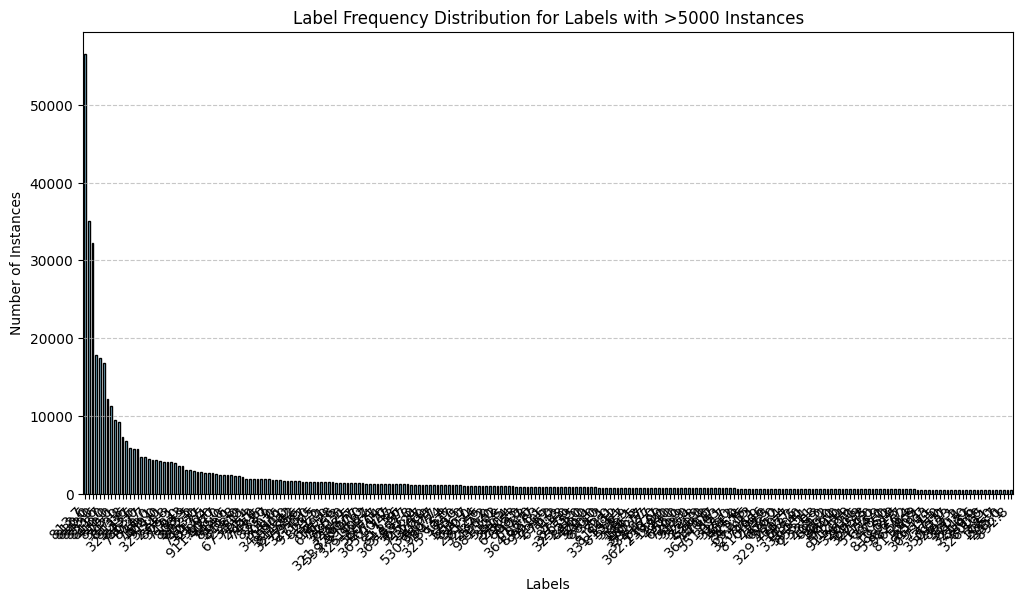

In [ ]:
# 그래프 그리기
plt.figure(figsize=(12, 6))
df_over500['KDC_NM'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Label Frequency Distribution for Labels with >5000 Instances')
plt.xlabel('Labels')
plt.ylabel('Number of Instances')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# KoBERT Model

In [18]:
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

  Cloning https://github.com/SKTBrain/KoBERT.git to /tmp/pip-install-kmnwoszs/kobert-tokenizer_68839959f99c42509e773a1a9e111d4b
  Running command git clone --filter=blob:none --quiet https://github.com/SKTBrain/KoBERT.git /tmp/pip-install-kmnwoszs/kobert-tokenizer_68839959f99c42509e773a1a9e111d4b
  Resolved https://github.com/SKTBrain/KoBERT.git to commit fcd729f2f4b37858f333597c0782388ada51eb5f
  Preparing metadata (setup.py) ... done
  Created wheel for kobert_tokenizer: filename=kobert_tokenizer-0.1-py3-none-any.whl size=4633 sha256=ebf5352b106da241031a3321a7c4d7e6d759d4a52edfaada52b5d9bd9a94c827
  Stored in directory: /tmp/pip-ephem-wheel-cache-pdpuzghw/wheels/b7/95/7c/3f38b039ae9422cc4a51702b37e352d0585442cbe60285f1f2
Successfully built kobert_tokenizer


In [ ]:
# !pip install mxnet
# !pip install gluonnlp pandas tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 48.0 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.3
    Uninstalling graphviz-0.20.3:
      Successfully uninstalled graphviz-0.20.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.5/344.5 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp311-cp311-linux_x86_64.whl size=679483 sha256=726da97a01f2812d1e67852164a11d2a2b6a9e15abf562de100932ad3bd0825a
  Stored in directory: /root/.cache/pip/wheels/29/64/e3/047328bfc4a551696adc4a82dba3c980a1dad62198b8a3bb83
Successfully built gluonnlp


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/371k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/244 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


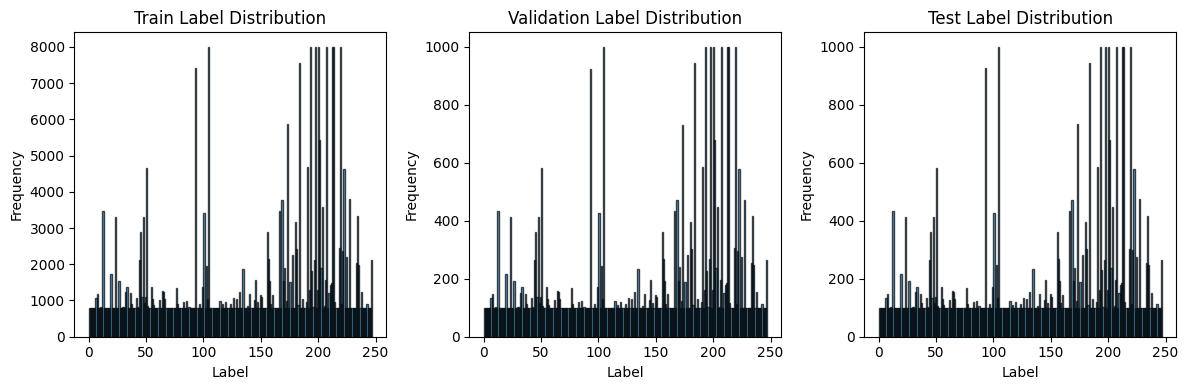

248


In [19]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm, tqdm_notebook
from kobert_tokenizer import KoBERTTokenizer
from torch.utils.data import Dataset, DataLoader, Subset
from transformers import BertTokenizer, BertModel, get_scheduler
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from torch.cuda.amp import GradScaler, autocast

# 데이터셋 정의
class BookDataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.label_to_index = {label: idx for idx, label in enumerate(sorted(data['KDC_NM'].dropna().astype(str).unique()))}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        title = item['TITLE_NM']
        description = item['description']
        label = str(item['KDC_NM'])

        label_idx = self.label_to_index[label]

        input_text = title + " " + description
        encoding = self.tokenizer(
            input_text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': label_idx
        }

# 모델 정의
class BERTClassifier(nn.Module):
    def __init__(self, bert_model, num_classes):
        super(BERTClassifier, self).__init__()
        self.bert = bert_model
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)

        for param in self.bert.parameters():
            param.requires_grad = True

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        logits = self.classifier(cls_output)
        return logits

# 하이퍼파라미터
MAX_LENGTH = 221
BATCH_SIZE = 32
LEARNING_RATE = 2e-5
EPOCHS = 20
GRAD_ACCUMULATION_STEPS = 4

# 데이터 준비
final_df['KDC_NM'] = final_df['KDC_NM'].astype(str)
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
dataset = BookDataset(final_df, tokenizer, MAX_LENGTH)

# 데이터셋 나누기
labels = final_df['KDC_NM'].astype(str).values
indices = list(range(len(final_df)))

train_indices, temp_indices = train_test_split(
    indices, test_size=0.2, stratify=labels, random_state=42
)
val_indices, test_indices = train_test_split(
    temp_indices, test_size=0.5, stratify=[labels[i] for i in temp_indices], random_state=42
)

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True, prefetch_factor=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True, prefetch_factor=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True, prefetch_factor=2)

# 데이터셋에서 라벨 추출
train_labels = [sample['label'] for sample in train_dataset]
val_labels = [sample['label'] for sample in val_dataset]
test_labels = [sample['label'] for sample in test_dataset]

# 라벨 분포 시각화
plt.figure(figsize=(12, 4))

# Train 데이터셋 라벨 분포
plt.subplot(1, 3, 1)
plt.hist(train_labels, bins=np.arange(min(train_labels), max(train_labels)+1, 1), edgecolor='black', alpha=0.7)
plt.title('Train Label Distribution')
plt.xlabel('Label')
plt.ylabel('Frequency')

# Validation 데이터셋 라벨 분포
plt.subplot(1, 3, 2)
plt.hist(val_labels, bins=np.arange(min(val_labels), max(val_labels)+1, 1), edgecolor='black', alpha=0.7)
plt.title('Validation Label Distribution')
plt.xlabel('Label')
plt.ylabel('Frequency')

# Test 데이터셋 라벨 분포
plt.subplot(1, 3, 3)
plt.hist(test_labels, bins=np.arange(min(test_labels), max(test_labels)+1, 1), edgecolor='black', alpha=0.7)
plt.title('Test Label Distribution')
plt.xlabel('Label')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# 데이터셋에서 레이블별 샘플 개수 계산
from collections import Counter

# Extract labels from the dataset's data attribute
labels = dataset.data['KDC_NM'].astype(str).tolist()
label_counts = Counter([dataset.label_to_index[label] for label in labels])

# 클래스 가중치 계산: 전체 샘플 수 / (클래스 수 * 해당 클래스 샘플 수)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(dataset.label_to_index)  # Replace with your model's actual number of output classes
total_samples = sum(label_counts.values())
print(num_classes)

# 가중치 리스트 초기화
class_weights = [total_samples / (num_classes * label_counts.get(i, 1)) for i in range(num_classes)]

# 가중치를 텐서로 변환
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

In [ ]:
# 'KDC_NM' 열을 문자열로 변환
final_df['KDC_NM'] = final_df['KDC_NM'].astype(str)

# 데이터셋의 고유 라벨 확인
unique_labels = final_df['KDC_NM'].unique()
print(f"데이터셋 고유 라벨 개수: {len(unique_labels)}")

# 매핑 테이블 확인
print(f"매핑 테이블 크기: {len(dataset.label_to_index)}")  # 18141 출력 예상

# 매핑 테이블에 데이터셋의 고유 라벨이 모두 포함되어 있는지 확인
missing_labels = [label for label in unique_labels if label not in dataset.label_to_index]
if missing_labels:
    print(f"매핑되지 않은 라벨: {missing_labels}")
else:
    print("모든 라벨이 매핑되었습니다.")

데이터셋 고유 라벨 개수: 248
매핑 테이블 크기: 248
모든 라벨이 매핑되었습니다.


## 5000개 이상



In [ ]:
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
import numpy as np

# 모델 준비
bert_model = BertModel.from_pretrained('skt/kobert-base-v1', return_dict=True)
model = BERTClassifier(bert_model, len(dataset.label_to_index))
model.to(device)

# 옵티마이저 및 스케줄러
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * EPOCHS)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
scaler = GradScaler()

# 정확도 계산 함수
def calculate_accuracy(logits, labels):
    preds = torch.argmax(logits, dim=1)
    correct = (preds == labels).sum().item()
    return correct / len(labels)

# Early Stopping 설정
best_val_loss = float('inf')
patience = 3  # 성능 향상이 없는 epoch 수
patience_counter = 0

# 모델 저장 경로
best_model_path = "best_model.pth"

# 학습 및 검증 기록을 저장할 리스트
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

# 학습 및 검증 루프
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    total_acc = 0

    for i, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch + 1}/{EPOCHS} [Training]")):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()

        with autocast():
            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels) / GRAD_ACCUMULATION_STEPS

        scaler.scale(loss).backward()

        if (i + 1) % GRAD_ACCUMULATION_STEPS == 0 or (i + 1) == len(train_loader):
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            optimizer.zero_grad()

        total_loss += loss.item() * GRAD_ACCUMULATION_STEPS
        total_acc += calculate_accuracy(logits, labels)

    avg_train_loss = total_loss / len(train_loader)
    avg_train_acc = total_acc / len(train_loader)

    # 검증 루프
    model.eval()
    val_loss = 0
    val_acc = 0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{EPOCHS} [Validation]"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            with autocast():
                logits = model(input_ids, attention_mask)
                loss = criterion(logits, labels)

            val_loss += loss.item()
            val_acc += calculate_accuracy(logits, labels)

    avg_val_loss = val_loss / len(val_loader)
    avg_val_acc = val_acc / len(val_loader)

    # 학습/검증 손실 및 정확도 출력
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_acc:.4f}")
    print(f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_acc:.4f}")

    # Early Stopping 체크
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0  # 성능 향상 시 카운터 초기화
        torch.save(model.state_dict(), best_model_path)  # 가장 좋은 모델 저장
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch + 1} due to no improvement in validation loss.")
        break

    # 리스트에 값 저장
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_acc)

# 🔹 학습이 끝난 후, 가장 잘 나온 모델 불러오기
model.load_state_dict(torch.load(best_model_path))

# 🔹 학습이 끝난 후 테스트 세트에서 F1, Recall, ROC AUC 계산
model.eval()
test_preds = []
test_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        logits = model(input_ids, attention_mask)

        # 예측값 저장
        preds = torch.argmax(logits, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

        # 확률값 저장 (softmax)
        probabilities = F.softmax(logits, dim=1)  # 각 클래스에 대한 확률
        test_probabilities.extend(probabilities.cpu().numpy())

# F1 Score, Recall, ROC AUC 계산 (테스트 세트에서)
precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(test_labels, test_preds, average="micro")
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(test_labels, test_preds, average="macro")

# 테스트 세트 성능 출력
print(f"\nTest Set Performance:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"F1 Micro: {f1_micro:.4f}, F1 Macro: {f1_macro:.4f}")
print(f"Recall Micro: {recall_micro:.4f}, Recall Macro: {recall_macro:.4f}, ROC AUC: {roc_auc:.4f}")

# 🔹 학습이 끝난 후 결과 시각화
epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(15, 7))

# Loss 그래프
plt.subplot(2, 2, 1)
plt.plot(epochs_range, train_losses, label="Train Loss", marker='o')
plt.plot(epochs_range, val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid()

# Accuracy 그래프
plt.subplot(2, 2, 2)
plt.plot(epochs_range, train_accuracies, label="Train Accuracy", marker='o')
plt.plot(epochs_range, val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

config.json:   0%|          | 0.00/535 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/369M [00:00<?, ?B/s]

/tmp/ipython-input-18-716834336.py:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/20 [Training]:   0%|          | 0/11314 [00:00<?, ?it/s]/tmp/ipython-input-18-716834336.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/20 [Validation]:   0%|          | 0/1415 [00:00<?, ?it/s]/tmp/ipython-input-18-716834336.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/20 [Validation]: 100%|██████████| 1415/1415 [00:22<00:00, 63.95it/s]


Epoch 1/20
Train Loss: 3.0957, Train Accuracy: 0.4443
Val Loss: 1.6864, Val Accuracy: 0.5913


Epoch 2/20 [Validation]: 100%|██████████| 1415/1415 [00:22<00:00, 63.88it/s]


Epoch 2/20
Train Loss: 1.4593, Train Accuracy: 0.5932
Val Loss: 1.1702, Val Accuracy: 0.6199


Epoch 3/20 [Validation]: 100%|██████████| 1415/1415 [00:22<00:00, 62.91it/s]


Epoch 3/20
Train Loss: 1.1177, Train Accuracy: 0.6276
Val Loss: 1.0491, Val Accuracy: 0.6332


Epoch 4/20 [Validation]: 100%|██████████| 1415/1415 [00:22<00:00, 63.86it/s]


Epoch 4/20
Train Loss: 0.9765, Train Accuracy: 0.6486
Val Loss: 0.9616, Val Accuracy: 0.6649


Epoch 5/20 [Validation]: 100%|██████████| 1415/1415 [00:22<00:00, 62.56it/s]


Epoch 5/20
Train Loss: 0.8900, Train Accuracy: 0.6650
Val Loss: 0.9301, Val Accuracy: 0.6439


Epoch 6/20 [Validation]: 100%|██████████| 1415/1415 [00:22<00:00, 63.90it/s]


Epoch 6/20
Train Loss: 0.8252, Train Accuracy: 0.6795
Val Loss: 0.8868, Val Accuracy: 0.6624


Epoch 7/20 [Validation]: 100%|██████████| 1415/1415 [00:22<00:00, 63.97it/s]


Epoch 7/20
Train Loss: 0.7691, Train Accuracy: 0.6940
Val Loss: 0.8658, Val Accuracy: 0.6817


Epoch 8/20 [Validation]: 100%|██████████| 1415/1415 [00:22<00:00, 62.83it/s]


Epoch 8/20
Train Loss: 0.7221, Train Accuracy: 0.7030
Val Loss: 0.8445, Val Accuracy: 0.6773


Epoch 9/20 [Validation]: 100%|██████████| 1415/1415 [00:22<00:00, 63.79it/s]


Epoch 9/20
Train Loss: 0.6806, Train Accuracy: 0.7160
Val Loss: 0.8305, Val Accuracy: 0.6889


Epoch 10/20 [Validation]: 100%|██████████| 1415/1415 [00:22<00:00, 64.12it/s]


Epoch 10/20
Train Loss: 0.6435, Train Accuracy: 0.7254
Val Loss: 0.8256, Val Accuracy: 0.6927


Epoch 11/20 [Validation]: 100%|██████████| 1415/1415 [00:22<00:00, 62.21it/s]


Epoch 11/20
Train Loss: 0.6062, Train Accuracy: 0.7351
Val Loss: 0.8158, Val Accuracy: 0.7057


Epoch 12/20 [Validation]: 100%|██████████| 1415/1415 [00:21<00:00, 64.96it/s]


Epoch 12/20
Train Loss: 0.5739, Train Accuracy: 0.7454
Val Loss: 0.8069, Val Accuracy: 0.7086


Epoch 13/20 [Validation]: 100%|██████████| 1415/1415 [00:22<00:00, 63.07it/s]


Epoch 13/20
Train Loss: 0.5447, Train Accuracy: 0.7553
Val Loss: 0.8132, Val Accuracy: 0.7125


Epoch 14/20 [Validation]: 100%|██████████| 1415/1415 [00:22<00:00, 63.34it/s]


Epoch 14/20
Train Loss: 0.5165, Train Accuracy: 0.7609
Val Loss: 0.8096, Val Accuracy: 0.7186


Epoch 15/20 [Validation]: 100%|██████████| 1415/1415 [00:22<00:00, 63.76it/s]


Epoch 15/20
Train Loss: 0.4896, Train Accuracy: 0.7688
Val Loss: 0.8066, Val Accuracy: 0.7211


Epoch 16/20 [Validation]: 100%|██████████| 1415/1415 [00:21<00:00, 64.54it/s]


Epoch 16/20
Train Loss: 0.4657, Train Accuracy: 0.7780
Val Loss: 0.8132, Val Accuracy: 0.7159


Epoch 17/20 [Validation]: 100%|██████████| 1415/1415 [00:22<00:00, 64.00it/s]


Epoch 17/20
Train Loss: 0.4433, Train Accuracy: 0.7834
Val Loss: 0.8276, Val Accuracy: 0.7223


Epoch 18/20 [Validation]: 100%|██████████| 1415/1415 [00:22<00:00, 63.48it/s]


Epoch 18/20
Train Loss: 0.4189, Train Accuracy: 0.7905
Val Loss: 0.8146, Val Accuracy: 0.7233
Early stopping at epoch 18 due to no improvement in validation loss.


Testing:   0%|          | 0/1415 [00:00<?, ?it/s]


NameError: name 'test_probabilities' is not defined

In [21]:
from transformers import BertModel
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize
import torch.nn.functional as F
import torch

# 🔹 1. 모델 초기화 및 best_model.pth 불러오기
bert_model = BertModel.from_pretrained('skt/kobert-base-v1', return_dict=True)
model = BERTClassifier(bert_model, len(dataset.label_to_index))
model.load_state_dict(torch.load("best_model.pth"))
model.to(device)
model.eval()

# 🔹 2. 테스트셋에서 예측값, 실제값, softmax 확률 수집
test_preds = []
test_labels = []
test_probabilities = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        logits = model(input_ids, attention_mask)

        preds = torch.argmax(logits, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

        probabilities = F.softmax(logits, dim=1)
        test_probabilities.extend(probabilities.cpu().numpy())

# 🔹 3. 정확도 계산
test_accuracy = accuracy_score(test_labels, test_preds)

# 🔹 4. Precision, Recall, F1
precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(test_labels, test_preds, average="micro")
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(test_labels, test_preds, average="macro")

# 🔹 5. ROC AUC 계산
num_classes = len(dataset.label_to_index)
test_labels_onehot = label_binarize(test_labels, classes=list(range(num_classes)))
roc_auc = roc_auc_score(test_labels_onehot, test_probabilities, average="macro", multi_class="ovr")

# 🔹 6. 출력
print(f"\n🔹 Test Set Performance:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"F1 Micro: {f1_micro:.4f}, F1 Macro: {f1_macro:.4f}")
print(f"Recall Micro: {recall_micro:.4f}, Recall Macro: {recall_macro:.4f}")
print(f"ROC AUC (macro): {roc_auc:.4f}")

config.json:   0%|          | 0.00/535 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/369M [00:00<?, ?B/s]

Testing: 100%|██████████| 1415/1415 [01:52<00:00, 12.53it/s]



🔹 Test Set Performance:
Accuracy: 0.7227
F1 Micro: 0.7227, F1 Macro: 0.7677
Recall Micro: 0.7227, Recall Macro: 0.7930
ROC AUC (macro): 0.9953


In [24]:
from sklearn.metrics import accuracy_score

# 숫자 → 문자열 라벨 변환
index_to_label = {v: k for k, v in dataset.label_to_index.items()}
test_labels_str = [index_to_label[i] for i in test_labels]
test_preds_str = [index_to_label[i] for i in test_preds]

# ✅ level1~3은 항상 존재, level4는 조건부로 계산
def parse_kdc_levels(kdc_codes):
    level1, level2, level3, level4 = [], [], [], []
    has_decimal = []  # 소수점 있는지 여부
    for code in kdc_codes:
        main = code.split(".")[0].zfill(3)
        decimal_part = code.split(".")[1] if "." in code else None

        level1.append(main[0])
        level2.append(main[1])
        level3.append(main[2])

        if decimal_part is not None and len(decimal_part) > 0:
            level4.append(decimal_part[0])
            has_decimal.append(True)
        else:
            level4.append(None)  # placeholder
            has_decimal.append(False)

    return level1, level2, level3, level4, has_decimal

# 레벨별 분리
true_level1, true_level2, true_level3, true_level4, true_mask = parse_kdc_levels(test_labels_str)
pred_level1, pred_level2, pred_level3, pred_level4, pred_mask = parse_kdc_levels(test_preds_str)

# Accuracy 계산 (level 1~3)
acc1 = accuracy_score(true_level1, pred_level1)
acc2 = accuracy_score(true_level2, pred_level2)
acc3 = accuracy_score(true_level3, pred_level3)

# ✅ level4는 소수점 있는 샘플만 필터링해서 계산
valid_indices = [i for i, has_dec in enumerate(true_mask) if has_dec]

filtered_true_level4 = [true_level4[i] for i in valid_indices]
filtered_pred_level4 = [pred_level4[i] for i in valid_indices]

# ✅ level4는 true와 pred 둘 다 소수점 있는 샘플만 필터링
valid_indices = [
    i for i in range(len(true_level4))
    if true_level4[i] is not None and pred_level4[i] is not None
]

filtered_true_level4 = [true_level4[i] for i in valid_indices]
filtered_pred_level4 = [pred_level4[i] for i in valid_indices]

# 정확도 계산
acc4 = accuracy_score(filtered_true_level4, filtered_pred_level4)

# 전체 코드 정확도
acc_full = accuracy_score(test_labels_str, test_preds_str)

# 출력
print(f"✅ Level 1 Accuracy: {acc1:.4f}")
print(f"✅ Level 2 Accuracy: {acc2:.4f}")
print(f"✅ Level 3 Accuracy: {acc3:.4f}")
print(f"✅ Level 4 Accuracy (only when decimal exists): {acc4:.4f}")
print(f"✅ Full KDC Code Match Accuracy: {acc_full:.4f}")

✅ Level 1 Accuracy: 0.9247
✅ Level 2 Accuracy: 0.8879
✅ Level 3 Accuracy: 0.8491
✅ Level 4 Accuracy (only when decimal exists): 0.8169
✅ Full KDC Code Match Accuracy: 0.7227


In [25]:
from sklearn.metrics import accuracy_score

# 숫자 → 문자열 라벨 변환
index_to_label = {v: k for k, v in dataset.label_to_index.items()}
test_labels_str = [index_to_label[i] for i in test_labels]
test_preds_str = [index_to_label[i] for i in test_preds]

# ✅ level1~3 + 소수점 뒷자리 최대 6자리까지 분해
def parse_kdc_levels(kdc_codes):
    level1, level2, level3 = [], [], []
    level4, level5, level6, level7, level8, level9 = [], [], [], [], [], []

    for code in kdc_codes:
        main = code.split(".")[0].zfill(3)
        decimal = code.split(".")[1] if "." in code else ""

        level1.append(main[0])
        level2.append(main[1])
        level3.append(main[2])
        level4.append(decimal[0] if len(decimal) > 0 else None)
        level5.append(decimal[1] if len(decimal) > 1 else None)
        level6.append(decimal[2] if len(decimal) > 2 else None)
        level7.append(decimal[3] if len(decimal) > 3 else None)
        level8.append(decimal[4] if len(decimal) > 4 else None)
        level9.append(decimal[5] if len(decimal) > 5 else None)

    return [level1, level2, level3, level4, level5, level6, level7, level8, level9]

# 레벨별 분리
true_levels = parse_kdc_levels(test_labels_str)
pred_levels = parse_kdc_levels(test_preds_str)

# ✅ level 1~3: 전체에 대해 계산 가능
accs = []
for i in range(3):
    acc = accuracy_score(true_levels[i], pred_levels[i])
    accs.append(acc)
    print(f"✅ Level {i+1} Accuracy: {acc:.4f}")

# ✅ level 4~9: None이 아닌 경우만 필터링해서 계산
for i in range(3, 9):
    valid_indices = [
        j for j in range(len(true_levels[i]))
        if true_levels[i][j] is not None and pred_levels[i][j] is not None
    ]
    filtered_true = [true_levels[i][j] for j in valid_indices]
    filtered_pred = [pred_levels[i][j] for j in valid_indices]

    if len(filtered_true) > 0:
        acc = accuracy_score(filtered_true, filtered_pred)
        accs.append(acc)
        print(f"✅ Level {i+1} Accuracy (decimal {i-2} digit): {acc:.4f}")
    else:
        print(f"⚠️ Level {i+1} Accuracy: 데이터 없음")

# ✅ 전체 일치율 (문자열 기반)
acc_full = accuracy_score(test_labels_str, test_preds_str)
print(f"✅ Full KDC Code Match Accuracy: {acc_full:.4f}")


✅ Level 1 Accuracy: 0.9247
✅ Level 2 Accuracy: 0.8879
✅ Level 3 Accuracy: 0.8491
✅ Level 4 Accuracy (decimal 1 digit): 0.8169
✅ Level 5 Accuracy (decimal 2 digit): 0.9517
✅ Level 6 Accuracy (decimal 3 digit): 0.9896
✅ Level 7 Accuracy (decimal 4 digit): 0.9974
✅ Level 8 Accuracy (decimal 5 digit): 1.0000
✅ Level 9 Accuracy (decimal 6 digit): 1.0000
✅ Full KDC Code Match Accuracy: 0.7227


In [34]:
# 소수점 뒷자리가 가장 긴 라벨 찾기
max_decimal_len = 0
longest_labels = []

for label in test_labels_str:
    if "." in label:
        decimal_part = label.split(".")[1]
        if len(decimal_part) > max_decimal_len:
            max_decimal_len = len(decimal_part)
            longest_labels = [label]
        elif len(decimal_part) == max_decimal_len:
            longest_labels.append(label)

print(f"📏 소수점 뒷자리가 가장 긴 길이: {max_decimal_len}")
print(f"🔎 해당하는 라벨들 예시: {longest_labels[:10]}")
print(f"총 {len(longest_labels)}개")


📏 소수점 뒷자리가 가장 긴 길이: 6
🔎 해당하는 라벨들 예시: ['321.329077', '321.329077', '321.329077', '321.329077', '321.329077', '321.329077', '321.329077', '321.329077', '321.329077', '321.329077']
총 135개


In [35]:
# 소수점 뒷자리가 정확히 길이 6인 라벨 개수 세기
count_len_6 = sum(
    1 for label in test_labels_str
    if "." in label and len(label.split(".")[1]) == 6
)

print(f"📌 소수점 뒷자리가 정확히 6자리인 라벨 수: {count_len_6}")

📌 소수점 뒷자리가 정확히 6자리인 라벨 수: 135


/tmp/ipython-input-29-2726518144.py:45: UserWarning: Glyph 45800 (\N{HANGUL SYLLABLE DAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-29-2726518144.py:45: UserWarning: Glyph 50948 (\N{HANGUL SYLLABLE WI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45800 (\N{HANGUL SYLLABLE DAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50948 (\N{HANGUL SYLLABLE WI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


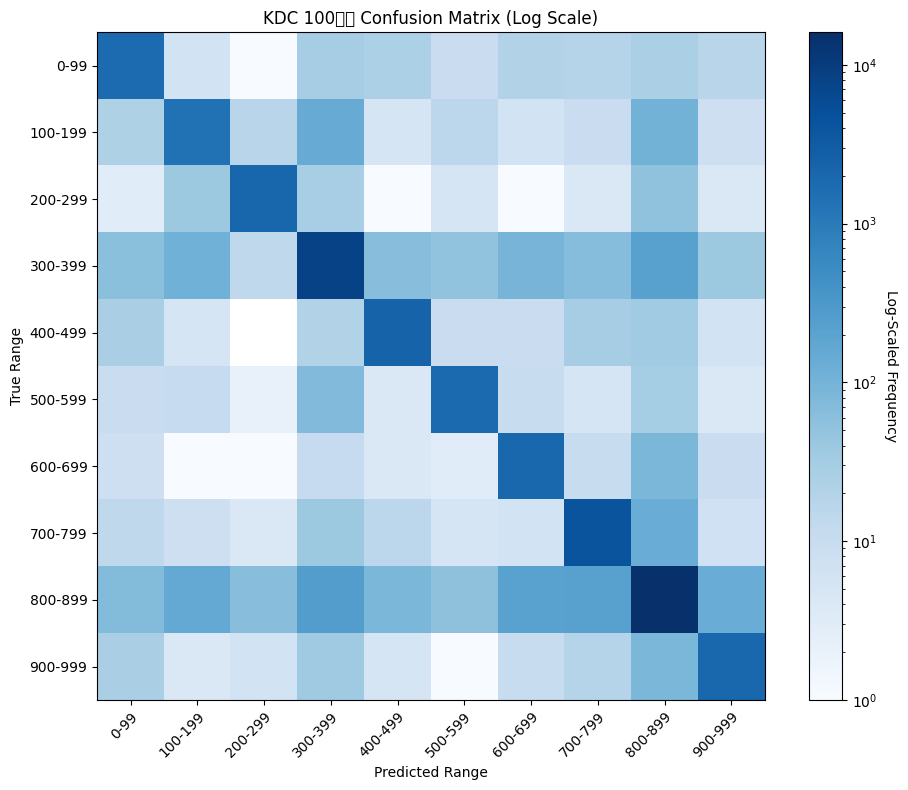

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from matplotlib.colors import LogNorm

# 문자열 라벨로 변환
test_labels_str = [index_to_label[i] for i in test_labels]
test_preds_str = [index_to_label[i] for i in test_preds]

# main class만 추출: 정수화 후 100 단위 그룹화
def extract_main_class_group(label):
    main = int(label.split(".")[0])
    return (main // 100) * 100

# 그룹화된 라벨 리스트 생성
grouped_true = [extract_main_class_group(lab) for lab in test_labels_str]
grouped_pred = [extract_main_class_group(lab) for lab in test_preds_str]

# 고유 그룹 정렬
unique_groups = sorted(set(grouped_true + grouped_pred))
conf_matrix = confusion_matrix(grouped_true, grouped_pred, labels=unique_groups)

# display labels
display_labels = [f"{g}-{g+99}" for g in unique_groups]

# 시각화 - imshow 직접 사용
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues, norm=LogNorm(vmin=1, vmax=conf_matrix.max()))

# 컬러바
cbar = fig.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Log-Scaled Frequency", rotation=270, labelpad=15)

# 라벨 설정
ax.set(
    xticks=range(len(display_labels)),
    yticks=range(len(display_labels)),
    xticklabels=display_labels,
    yticklabels=display_labels,
    xlabel="Predicted Range",
    ylabel="True Range",
    title="KDC 100단위 Confusion Matrix (Log Scale)"
)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.grid(False)
plt.tight_layout()
plt.show()


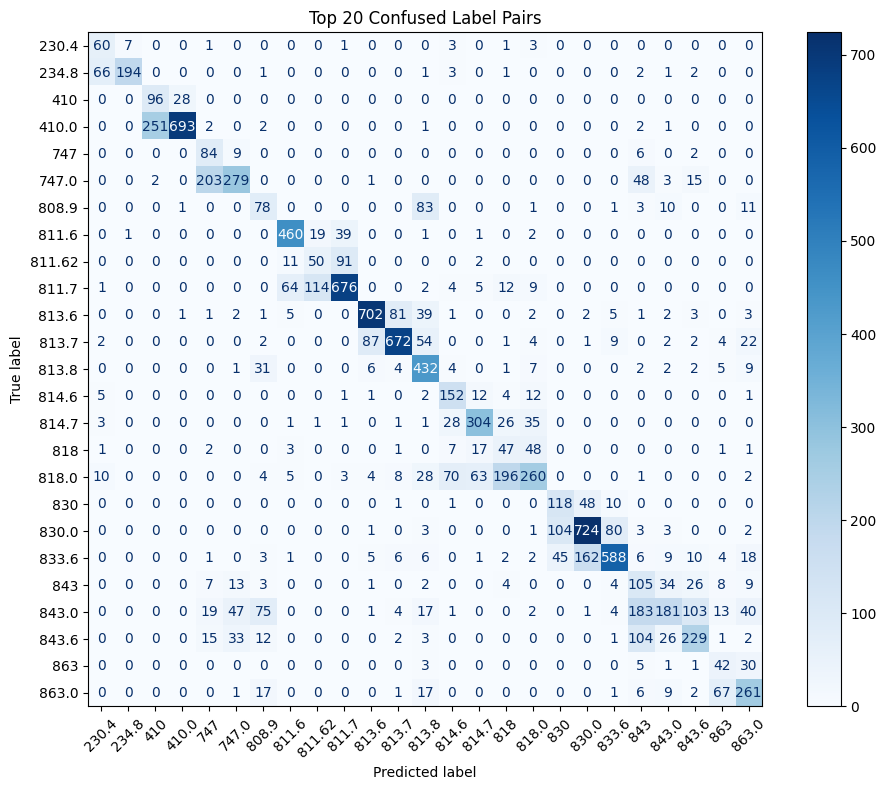

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1) 문자열 라벨 준비
labels = test_labels_str
preds  = test_preds_str

# 2) 고유 라벨 순서대로 정렬
unique_labels = sorted(set(labels))
# (이 리스트가 confusion_matrix 행·열 순서와 1:1 매핑됩니다)

# 3) 혼동 행렬 + error matrix
cm          = confusion_matrix(labels, preds, labels=unique_labels)
error_mtx   = cm.copy()
np.fill_diagonal(error_mtx, 0)

# 4) 상위 20개 오분류 인덱스 (가장 큰 값부터)
flat_idxs = np.argsort(error_mtx.flatten())[::-1]  # 내림차순
top_idxs  = flat_idxs[:20]
pairs     = [np.unravel_index(idx, error_mtx.shape) for idx in top_idxs]

# 5) 라벨 쌍으로 변환
top_pairs = [(unique_labels[i], unique_labels[j]) for i,j in pairs]

# 6) 포함된 라벨 모아서 부분 confusion matrix
labels_of_interest = sorted({t for t,p in top_pairs} | {p for t,p in top_pairs})
sub_cm = confusion_matrix(labels, preds, labels=labels_of_interest)

# 7) 시각화
fig, ax = plt.subplots(figsize=(10,8))
disp = ConfusionMatrixDisplay(sub_cm, display_labels=labels_of_interest)
disp.plot(cmap=plt.cm.Blues, include_values=True, ax=ax, xticks_rotation=45)
plt.title("Top 20 Confused Label Pairs")
plt.tight_layout()
plt.show()


In [45]:
import numpy as np
from sklearn.metrics import confusion_matrix

# ✅ confusion matrix 계산
conf_matrix = confusion_matrix(test_labels, test_preds)

# ✅ 대각선 제거 (정확한 예측 제거)
error_matrix = conf_matrix.copy()
np.fill_diagonal(error_matrix, 0)

# ✅ 가장 큰 오차 10개 찾기
top_misclassifications = np.unravel_index(
    np.argsort(error_matrix, axis=None)[-20:], error_matrix.shape
)

# ✅ 클래스 이름 정의 (정수라면 그냥 숫자, 문자열이라면 변환)
# 예: class_names = [index_to_label[i] for i in sorted(set(test_labels))]
class_names = sorted(set(test_labels))  # 또는 test_labels_str 기반 처리 가능

# ✅ 상위 오분류 클래스쌍 출력
print("🔍 Top 10 Most Confused Class Pairs:")
for true_class, pred_class in zip(*top_misclassifications[::-1]):
    count = error_matrix[true_class, pred_class]
    if count > 0:
        print(f"True: {class_names[true_class]}, Pred: {class_names[pred_class]}, Count: {count}")


🔍 Top 10 Most Confused Class Pairs:
True: 203, Pred: 207, Count: 35
True: 190, Pred: 193, Count: 39
True: 16, Pred: 23, Count: 7
True: 226, Pred: 227, Count: 30
True: 202, Pred: 207, Count: 12
True: 181, Pred: 219, Count: 10
True: 213, Pred: 212, Count: 162
True: 200, Pred: 197, Count: 87
True: 201, Pred: 181, Count: 31
True: 197, Pred: 200, Count: 81
True: 193, Pred: 192, Count: 114
True: 222, Pred: 219, Count: 26
True: 218, Pred: 222, Count: 26
True: 211, Pred: 212, Count: 48
True: 192, Pred: 193, Count: 91
True: 212, Pred: 213, Count: 80
True: 218, Pred: 219, Count: 34
True: 206, Pred: 207, Count: 48
True: 172, Pred: 173, Count: 9
True: 103, Pred: 104, Count: 28


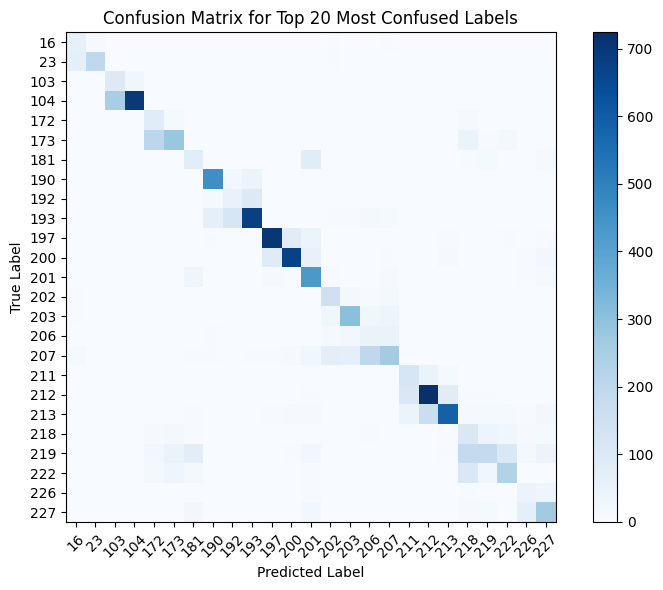

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# (1) 이미 구해놓은 error_matrix 와 class_names, test_labels, test_preds 가 있다고 가정
#     그리고 flat_idxs, top_idxs, row_idx, col_idx 까지 계산된 상태여야 합니다.

# 예시로 다시 계산해보면:
conf_matrix = confusion_matrix(test_labels, test_preds)
error_matrix = conf_matrix.copy()
np.fill_diagonal(error_matrix, 0)
flat_idxs = np.argsort(error_matrix.flatten())[::-1]
top_k = 20
top_idxs = flat_idxs[:top_k]
row_idx, col_idx = np.unravel_index(top_idxs, error_matrix.shape)

# (2) 관심 있는 라벨 인덱스 집합 생성
labels_of_interest_idx = sorted(set(row_idx.tolist() + col_idx.tolist()))

# (3) 인덱스를 실제 문자열 라벨로 매핑
#     class_names[i] 가 i번 인덱스의 문자열 라벨이라고 가정합니다.
display_labels = [class_names[i] for i in labels_of_interest_idx]

# (4) 부분 confusion matrix 계산 (정수 인덱스 기준)
sub_cm = confusion_matrix(
    test_labels,
    test_preds,
    labels=labels_of_interest_idx
)

# (5) 시각화
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=sub_cm, display_labels=display_labels)
disp.plot(
    cmap=plt.cm.Blues,
    include_values=False,
    xticks_rotation=45,
    ax=ax
)
plt.title("Confusion Matrix for Top 20 Most Confused Labels")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


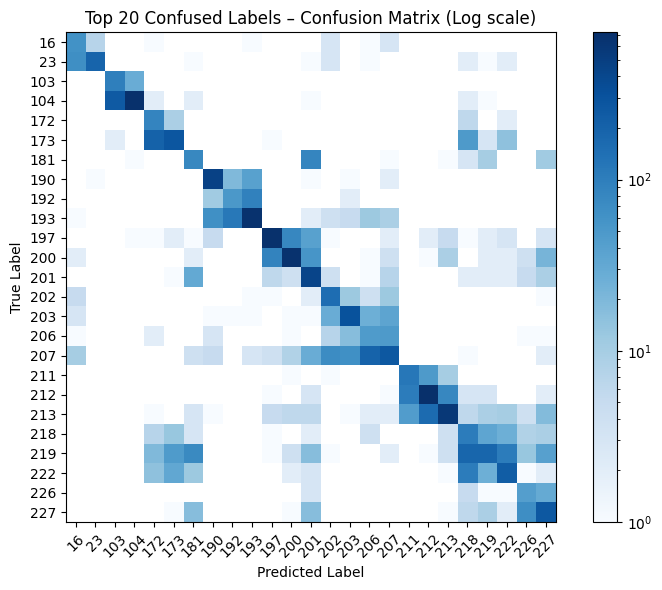

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib.colors import LogNorm

# 1) 전체 혼동행렬 → 오분류 행렬
conf_matrix = confusion_matrix(test_labels, test_preds)
error_matrix = conf_matrix.copy()
np.fill_diagonal(error_matrix, 0)

# 2) 상위 20개 오분류 인덱스(내림차순)
flat_idxs = np.argsort(error_matrix.flatten())[::-1]
top_k = 20
top_idxs = flat_idxs[:top_k]
row_idx, col_idx = np.unravel_index(top_idxs, error_matrix.shape)

# 3) 관심 있는 라벨 인덱스 & 문자열 라벨
labels_of_interest_idx = sorted(set(row_idx.tolist() + col_idx.tolist()))
display_labels = [class_names[i] for i in labels_of_interest_idx]

# 4) 부분 혼동행렬 계산
sub_cm = confusion_matrix(
    test_labels,
    test_preds,
    labels=labels_of_interest_idx
)

# 5) LogNorm 설정
norm = LogNorm(vmin=1, vmax=sub_cm.max())

# 6) 시각화
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=sub_cm, display_labels=display_labels)
disp.plot(
    cmap=plt.cm.Blues,
    include_values=False,
    xticks_rotation=45,
    ax=ax
)

# ⚙️ 이미지에 로그 스케일 적용
disp.im_.set_norm(norm)

plt.title("Top 20 Confused Labels – Confusion Matrix (Log scale)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


## 1000개 이상

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
import numpy as np

# 모델 준비
bert_model = BertModel.from_pretrained('skt/kobert-base-v1', return_dict=True)
model = BERTClassifier(bert_model, len(dataset.label_to_index))
model.to(device)

# 옵티마이저 및 스케줄러
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * EPOCHS)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
scaler = GradScaler()

# 정확도 계산 함수
def calculate_accuracy(logits, labels):
    preds = torch.argmax(logits, dim=1)
    correct = (preds == labels).sum().item()
    return correct / len(labels)

# Early Stopping 설정
best_val_loss = float('inf')
patience = 3  # 성능 향상이 없는 epoch 수
patience_counter = 0

# 모델 저장 경로
best_model_path = "best_model.pth"

# 학습 및 검증 기록을 저장할 리스트
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

# 학습 및 검증 루프
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    total_acc = 0

    for i, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch + 1}/{EPOCHS} [Training]")):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()

        with autocast():
            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels) / GRAD_ACCUMULATION_STEPS

        scaler.scale(loss).backward()

        if (i + 1) % GRAD_ACCUMULATION_STEPS == 0 or (i + 1) == len(train_loader):
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            optimizer.zero_grad()

        total_loss += loss.item() * GRAD_ACCUMULATION_STEPS
        total_acc += calculate_accuracy(logits, labels)

    avg_train_loss = total_loss / len(train_loader)
    avg_train_acc = total_acc / len(train_loader)

    # 검증 루프
    model.eval()
    val_loss = 0
    val_acc = 0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{EPOCHS} [Validation]"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            with autocast():
                logits = model(input_ids, attention_mask)
                loss = criterion(logits, labels)

            val_loss += loss.item()
            val_acc += calculate_accuracy(logits, labels)

    avg_val_loss = val_loss / len(val_loader)
    avg_val_acc = val_acc / len(val_loader)

    # 학습/검증 손실 및 정확도 출력
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_acc:.4f}")
    print(f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_acc:.4f}")

    # Early Stopping 체크
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0  # 성능 향상 시 카운터 초기화
        torch.save(model.state_dict(), best_model_path)  # 가장 좋은 모델 저장
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch + 1} due to no improvement in validation loss.")
        break

    # 리스트에 값 저장
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_acc)

# 🔹 학습이 끝난 후, 가장 잘 나온 모델 불러오기
model.load_state_dict(torch.load(best_model_path))

# 🔹 학습이 끝난 후 테스트 세트에서 F1, Recall, ROC AUC 계산
model.eval()
test_preds = []
test_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        logits = model(input_ids, attention_mask)

        # 예측값 저장
        preds = torch.argmax(logits, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

        # 확률값 저장 (softmax)
        probabilities = F.softmax(logits, dim=1)  # 각 클래스에 대한 확률
        test_probabilities.extend(probabilities.cpu().numpy())

# F1 Score, Recall, ROC AUC 계산 (테스트 세트에서)
f1_micro = precision_recall_fscore_support(test_labels, test_preds, average="micro")[2]
f1_macro = precision_recall_fscore_support(test_labels, test_preds, average="macro")[2]

recall_micro = precision_recall_fscore_support(test_labels, test_preds, average="micro")[1]
recall_macro = precision_recall_fscore_support(test_labels, test_preds, average="macro")[1]

try:
    roc_auc = roc_auc_score(test_labels, test_probabilities, multi_class="ovr")
except ValueError:
    roc_auc = 0  # 예외 처리 (ROC AUC 계산 불가할 경우 0으로 설정)

# Accuracy 계산
test_accuracy = calculate_accuracy(np.array(test_preds), np.array(test_labels))

# 테스트 세트 성능 출력
print(f"\nTest Set Performance:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"F1 Micro: {f1_micro:.4f}, F1 Macro: {f1_macro:.4f}")
print(f"Recall Micro: {recall_micro:.4f}, Recall Macro: {recall_macro:.4f}, ROC AUC: {roc_auc:.4f}")

# 🔹 학습이 끝난 후 결과 시각화
epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(15, 7))

# Loss 그래프
plt.subplot(2, 2, 1)
plt.plot(epochs_range, train_losses, label="Train Loss", marker='o')
plt.plot(epochs_range, val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid()

# Accuracy 그래프
plt.subplot(2, 2, 2)
plt.plot(epochs_range, train_accuracies, label="Train Accuracy", marker='o')
plt.plot(epochs_range, val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

config.json:   0%|          | 0.00/535 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/369M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/40 [Validation]: 100%|██████████| 1415/1415 [03:11<00:00,  7.39it/s]


Epoch 1/40
Train Loss: 3.1544, Train Accuracy: 0.4286
Val Loss: 1.7286, Val Accuracy: 0.5808


Epoch 2/40 [Validation]: 100%|██████████| 1415/1415 [03:11<00:00,  7.40it/s]


Epoch 2/40
Train Loss: 1.4802, Train Accuracy: 0.5899
Val Loss: 1.2283, Val Accuracy: 0.5920


Epoch 3/40 [Validation]: 100%|██████████| 1415/1415 [03:11<00:00,  7.41it/s]


Epoch 3/40
Train Loss: 1.1236, Train Accuracy: 0.6218
Val Loss: 1.0831, Val Accuracy: 0.6320


Epoch 4/40 [Validation]: 100%|██████████| 1415/1415 [03:11<00:00,  7.38it/s]


Epoch 4/40
Train Loss: 0.9842, Train Accuracy: 0.6436
Val Loss: 0.9994, Val Accuracy: 0.6586


Epoch 5/40 [Validation]: 100%|██████████| 1415/1415 [03:11<00:00,  7.38it/s]


Epoch 5/40
Train Loss: 0.8961, Train Accuracy: 0.6618
Val Loss: 0.9680, Val Accuracy: 0.6740


Epoch 6/40 [Validation]: 100%|██████████| 1415/1415 [03:12<00:00,  7.36it/s]


Epoch 6/40
Train Loss: 0.8352, Train Accuracy: 0.6784
Val Loss: 0.9349, Val Accuracy: 0.6783


Epoch 7/40 [Validation]: 100%|██████████| 1415/1415 [03:12<00:00,  7.34it/s]


Epoch 7/40
Train Loss: 0.7810, Train Accuracy: 0.6909
Val Loss: 0.9149, Val Accuracy: 0.6714


Epoch 8/40 [Validation]: 100%|██████████| 1415/1415 [03:11<00:00,  7.40it/s]


Epoch 8/40
Train Loss: 0.7283, Train Accuracy: 0.7032
Val Loss: 0.8845, Val Accuracy: 0.6850


Epoch 9/40 [Training]:  91%|█████████ | 10293/11314 [1:05:58<06:29,  2.62it/s]